In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
from models import CNNClassifier
from utils import create_param_list, create_train_data
import warnings
warnings.filterwarnings('ignore')

In [2]:
Q = 5
nconf = 31
ndata = 200
L = 64
T_cr = 0.852 # critical temp for 2d 5-Potts
t_start = 0.7

prm_list, t_end = create_param_list(nconf=nconf, t_start=t_start, L=L, model_name="2d_Potts", q=Q)
print(prm_list)
print(f"データ数:{nconf*ndata}")

[[0.7, '../dataset/2d_Potts/L64_q=5/L64T0_'], [0.71, '../dataset/2d_Potts/L64_q=5/L64T1_'], [0.72, '../dataset/2d_Potts/L64_q=5/L64T2_'], [0.73, '../dataset/2d_Potts/L64_q=5/L64T3_'], [0.74, '../dataset/2d_Potts/L64_q=5/L64T4_'], [0.75, '../dataset/2d_Potts/L64_q=5/L64T5_'], [0.76, '../dataset/2d_Potts/L64_q=5/L64T6_'], [0.77, '../dataset/2d_Potts/L64_q=5/L64T7_'], [0.78, '../dataset/2d_Potts/L64_q=5/L64T8_'], [0.79, '../dataset/2d_Potts/L64_q=5/L64T9_'], [0.8, '../dataset/2d_Potts/L64_q=5/L64T10_'], [0.81, '../dataset/2d_Potts/L64_q=5/L64T11_'], [0.82, '../dataset/2d_Potts/L64_q=5/L64T12_'], [0.83, '../dataset/2d_Potts/L64_q=5/L64T13_'], [0.84, '../dataset/2d_Potts/L64_q=5/L64T14_'], [0.85, '../dataset/2d_Potts/L64_q=5/L64T15_'], [0.86, '../dataset/2d_Potts/L64_q=5/L64T16_'], [0.87, '../dataset/2d_Potts/L64_q=5/L64T17_'], [0.88, '../dataset/2d_Potts/L64_q=5/L64T18_'], [0.89, '../dataset/2d_Potts/L64_q=5/L64T19_'], [0.9, '../dataset/2d_Potts/L64_q=5/L64T20_'], [0.91, '../dataset/2d_Pot

temperature:0.75


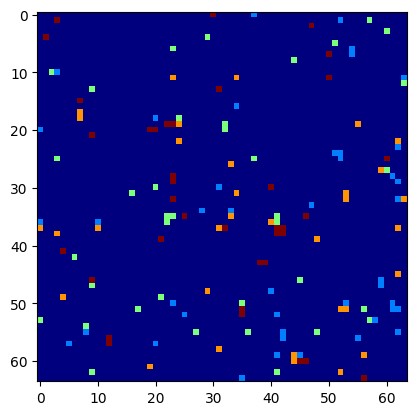

temperature:0.77


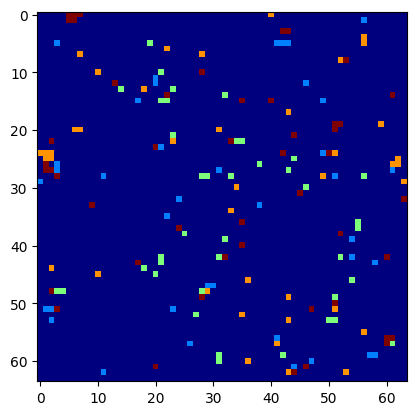

temperature:0.89


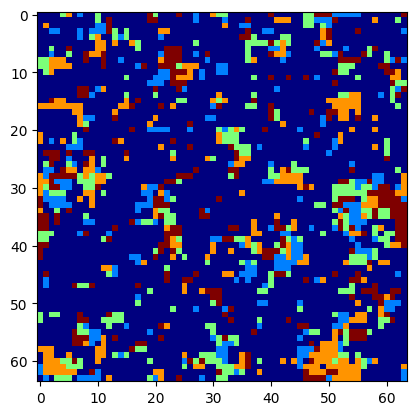

temperature:0.91


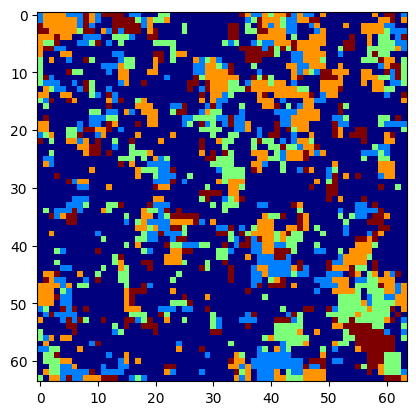

In [3]:
# 可視化
for num in [5, 7, 19, 21]:
    for iconf in range(1):
        file = f"{prm_list[num][1]}{iconf}.npy"
        sc = np.load(file)
        print(f"temperature:{prm_list[num][0]}")
        plt.imshow(sc, interpolation='nearest', vmin=0, vmax=Q-1, cmap='jet')
    plt.show()

In [4]:
train_data, vaild_data = create_train_data(prm_list, ndata, T_cr, exclude_T=(0.8, 0.9))

In [5]:
print("train_data.shape = ", len(train_data))
print("val_data.shape = ", len(vaild_data))

train_data.shape =  3000
val_data.shape =  2100


In [6]:
torch.manual_seed(3407)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
valid_loader = DataLoader(vaild_data, batch_size=100, shuffle=False)

In [7]:
model = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [8]:
epochs = 5
losses = []
accuracy_list = []
for epoch in range(epochs):
    model.train()
    for data, _, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.type(torch.long))
        loss.backward()
        del loss
        optimizer.step()
    
    model.eval()
    valid_loss = 0
    correct = 0
    answer = []
    prediction = []
    with torch.no_grad():
        for data, _, target in valid_loader:
            output = model(data)
            valid_loss += criterion(output, target.type(torch.long)).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            prediction += list(pred.cpu().numpy())
            answer += list(target.cpu().numpy())

    valid_loss /= len(valid_loader.dataset)
    accuracy = 100 * correct / len(valid_loader.dataset)
    losses.append(valid_loss)
    accuracy_list.append(accuracy)
    print(f'Epoch: {epoch+1}, Validation loss: {valid_loss}, Accuracy: {accuracy}%')
    print("Classification Report:\n", classification_report(
        answer, prediction, digits=4))
print("done.")
torch.save(model, "2d_Ising_model_classifier.pth")

Epoch: 1, Validation loss: 0.007081986779258365, Accuracy: 47.61904761904762%
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1100
           1     0.4762    1.0000    0.6452      1000

    accuracy                         0.4762      2100
   macro avg     0.2381    0.5000    0.3226      2100
weighted avg     0.2268    0.4762    0.3072      2100

Epoch: 2, Validation loss: 0.006937395107178461, Accuracy: 47.61904761904762%
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1100
           1     0.4762    1.0000    0.6452      1000

    accuracy                         0.4762      2100
   macro avg     0.2381    0.5000    0.3226      2100
weighted avg     0.2268    0.4762    0.3072      2100

Epoch: 3, Validation loss: 0.006934660190627689, Accuracy: 47.61904761904762%
Classification Report:
               precision    recall  f1-sc

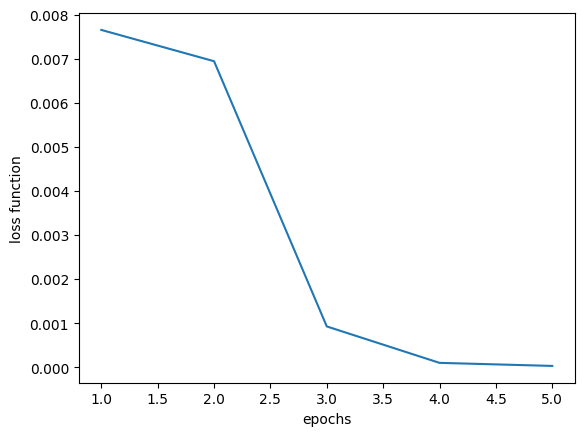

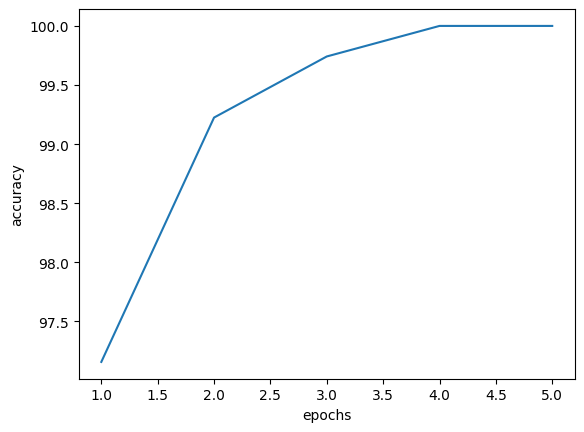

In [62]:
plt.xlabel('epochs')
plt.ylabel('loss function')
plt.plot(np.arange(1, epochs+1), losses)
plt.show()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(np.arange(1, epochs+1), accuracy_list)
plt.show()

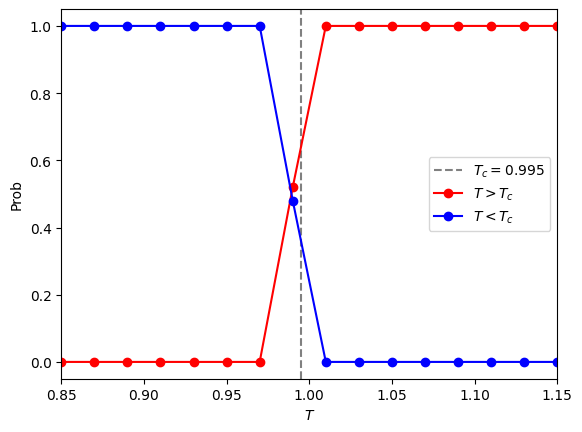

In [63]:
xs = []
y1s = []
y2s = []
temps = []
prediction = []
sum_pred = 0
count = 0

model.eval()
for data, temp, target in valid_loader:
    output = model(data)
    pred = output.argmax(dim=1, keepdim=False)
    prediction += list(pred.cpu().numpy())
    temps += list(temp.cpu().numpy())
# print(len(prediction), len(temps))

for i in range(len(vaild_data)):
    if i == 0:
        sum_pred += prediction[i]
        count += 1
        xs.append(temps[i])
    else:
        if temps[i] != temps[i-1]:
            # y1s, y2sに格納
            prob = sum_pred/count
            y1s.append(1 - prob)
            y2s.append(prob)

            sum_pred = 0
            count = 0
            sum_pred += prediction[i]
            count += 1
            xs.append(temps[i])
        elif i == len(vaild_data)-1:
            # y1s, y2sに格納
            prob = sum_pred/count
            y1s.append(1 - prob)
            y2s.append(prob)
        else:
            sum_pred += prediction[i]
            count += 1
# print(len(xs), len(y1s), len(y2s))

plt.axvline(x=T_cr, ymin=0, ymax=1, ls="dashed", color="gray", label=r"$T_c={T_cr}$")
plt.xlim(t_start,t_end)
plt.plot(xs, y1s, label=r"$para$", marker="o", color="red")
plt.plot(xs, y2s, label=r"$ferro$", marker="o", color="blue")
plt.legend()
plt.xlabel(r"$T$")
plt.ylabel(r"Probability")
plt.show()